In [18]:
## import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import shutil
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import VarianceThreshold



In [21]:
df = pd.read_csv("Data/comments.csv")
print(df.shape)
print(df.columns)

(1344, 2)
Index(['level', 'comments'], dtype='object')


In [4]:
reviews=[]
y=[]
#ITERATE OVER ROWS
# for i in range(0,10):  
for i in range(0,df.shape[0]):
    # QUICKLY CLEAN TEXT
    keep="abcdefghijklmnopqrstuvwxyz "
    replace=".,!;"
    tmp=""
    for char in df["comments"][i].replace("<br />","").lower():
        if char in replace:
            tmp+=" "
        if char in keep:
            tmp+=char
    tmp=" ".join(tmp.split())
    reviews.append(tmp)
    # CONVERT STRINGS TO INT TAGS
    if(df["level"][i]=="positive"):
        y.append(1)
    if(df["level"][i]=="negative"):
        y.append(0)

    #PRINT FIRST COUPLE REVIEWS
    if(i<3):
        print(i)
        print(df["comments"][i].replace("<br />",""),'\n')
        print(tmp)
        print(df["level"][i],y[i])

0
How does a bastard, orphan, son of a whore and a 

how does a bastard orphan son of a whore and a
negative 0
1
Scotsman, dropped in the middle of a forgotten 

scotsman dropped in the middle of a forgotten
negative 0
2
Spot in the Caribbean by providence, impoverished, in squalor 

spot in the caribbean by providence impoverished in squalor
negative 0


In [5]:
y=np.array(y)

In [7]:
def vectorize(corpus,MAX_FEATURES):
    vectorizer=CountVectorizer(max_features=MAX_FEATURES,stop_words="english")   
    # RUN COUNT VECTORIZER ON OUR COURPUS 
    Xs  =  vectorizer.fit_transform(corpus)   
    X=np.array(Xs.todense())
    #CONVERT TO ONE-HOT VECTORS (can also be done with binary=true in CountVectorizer)
    maxs=np.max(X,axis=0)
    return (np.ceil(X/maxs),vectorizer.vocabulary_)

(x,vocab0)=vectorize(reviews,MAX_FEATURES=10000)

In [8]:
df2=pd.DataFrame(x)
s = df2.sum(axis=0)
df2=df2[s.sort_values(ascending=False).index[:]]
print(df2.head())

   723   1315  795   405   1674  1205  167   836   639   1230  ...  652   \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

   633   651   650   646   645   643   642   636   1676  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1677 columns]


In [10]:
N = x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
test_index = l[cut:] # last 20% of shuffled list

print(train_index[0:10])
print(test_index[0:10])

[351, 1271, 1027, 1115, 920, 301, 260, 572, 1078, 779]
[1274, 86, 931, 1125, 1334, 471, 370, 1338, 915, 741]


In [12]:
def train_MNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # INITIALIZE MODEL 
    model = MultinomialNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval)

    return (acc_train,acc_test,time_train,time_eval)


#TEST
print(type(x),type(y))
print(x.shape,y.shape)
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,y,i_print=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1344, 1677) (1344,)
(1344, 1677) (1344,)
88.27906976744187 61.71003717472119 0.016790999999999556 0.00834899999999994


In [13]:
##UTILITY FUNCTION TO INITIALIZE RELEVANT ARRAYS
def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]

In [14]:
# INITIALIZE ARRAYS
initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        xtmp=x[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)

        if(i%5==0):
            print(i,upper_index,xtmp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtmp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=100, min_index=0, max_index=1000)

# SPARSE SEARCH (LARGE NUMBER OF FEATURES (SLOWER))
partial_grid_search(num_runs=20, min_index=1000, max_index=10000)

5 50 50 63.53488372093024 56.877323420074354
10 100 100 65.67441860465117 57.249070631970255
15 150 150 66.23255813953489 56.877323420074354
20 200 200 67.72093023255815 57.249070631970255
25 250 250 69.48837209302326 57.99256505576208
30 300 300 70.41860465116278 57.62081784386617
35 350 350 71.25581395348837 57.99256505576208
40 400 400 72.74418604651163 59.479553903345725
45 450 450 73.76744186046513 60.223048327137555
50 500 500 74.4186046511628 59.85130111524164
55 550 550 75.25581395348837 59.479553903345725
60 600 600 76.65116279069767 58.36431226765799
65 650 650 78.6046511627907 64.31226765799256
70 700 700 79.16279069767442 63.19702602230484
75 750 750 80.0 63.94052044609665
80 800 800 80.74418604651163 61.71003717472119
85 850 850 80.55813953488372 61.33828996282528
90 900 900 81.3953488372093 61.71003717472119
95 950 950 81.95348837209302 63.94052044609665
100 1000 1000 82.6046511627907 63.56877323420075
5 3250 1677 88.27906976744187 61.71003717472119
10 5500 1677 88.279069

In [15]:
#UTILITY FUNCTION TO PLOT RESULTS
def plot_results(path_root):

    #PLOT-1
    plt.plot(num_features,train_accuracies,'-or')
    plt.plot(num_features,test_accuracies,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (red) and Test (blue)')
    plt.savefig(path_root+'-1.png')
    plt.show()

    # #PLOT-2
    plt.plot(num_features,train_time,'-or')
    plt.plot(num_features,eval_time,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('Runtime: training time (red) and evaluation time(blue)')
    plt.savefig(path_root+'-2.png')
    plt.show()

    # #PLOT-3
    plt.plot(np.array(test_accuracies),train_time,'-or')
    plt.plot(np.array(test_accuracies),eval_time,'-ob')
    plt.xlabel('test_accuracies')
    plt.ylabel('Runtime: training time (red) and evaluation time (blue)')
    plt.savefig(path_root+'-3.png')
    plt.show()

    # #PLOT-3
    plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.savefig(path_root+'-4.png')
    plt.show()

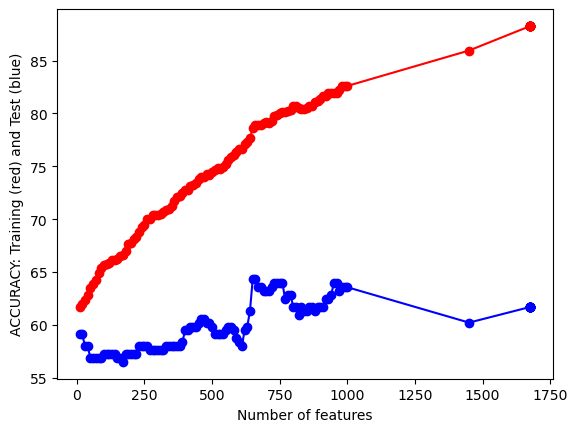

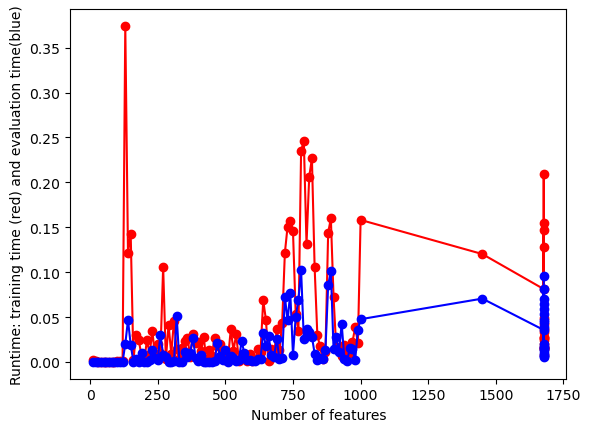

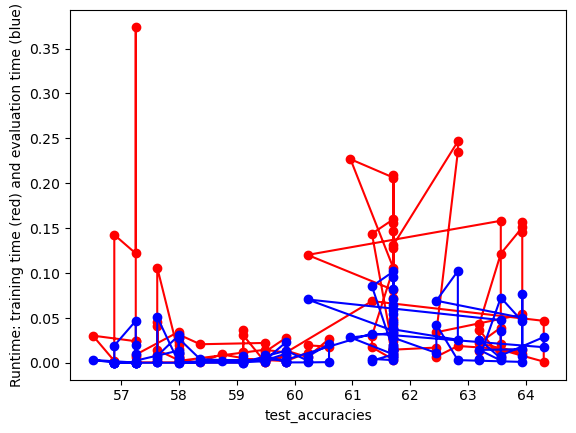

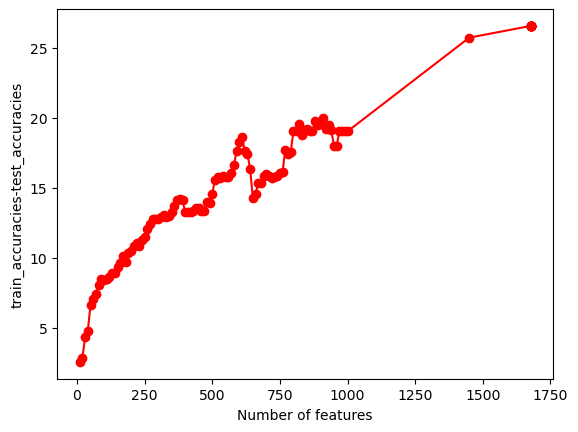

In [16]:
plot_results('results')

In [17]:
x_var=np.var(x,axis=0)
print(np.min(x_var))
print(np.max(x_var))

0.0007434940121882086
0.04197170404620044


In [19]:
from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

#DOESN"T WORK WELL WITH EDGE VALUES 
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
initialize_arrays()

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)
    print("THRESHOLD =",THRESHOLD, xtmp.shape[1])

    (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,y,i_print=False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    train_time.append(time_train)
    eval_time.append(time_eval)

THRESHOLD = 0.0021651564271541477 337
THRESHOLD = 0.0035868188421200866 143
THRESHOLD = 0.005008481257086026 86
THRESHOLD = 0.006430143672051965 61
THRESHOLD = 0.007851806087017903 45
THRESHOLD = 0.009273468501983842 36
THRESHOLD = 0.01069513091694978 27
THRESHOLD = 0.01211679333191572 21
THRESHOLD = 0.013538455746881659 18
THRESHOLD = 0.014960118161847598 17
THRESHOLD = 0.016381780576813536 12
THRESHOLD = 0.017803442991779477 11
THRESHOLD = 0.019225105406745418 8
THRESHOLD = 0.020646767821711355 6
THRESHOLD = 0.022068430236677292 5
THRESHOLD = 0.023490092651643233 5
THRESHOLD = 0.024911755066609174 4
THRESHOLD = 0.02633341748157511 4
THRESHOLD = 0.027755079896541048 4
THRESHOLD = 0.02917674231150699 2
THRESHOLD = 0.03059840472647293 2
THRESHOLD = 0.03202006714143886 1
THRESHOLD = 0.0334417295564048 1
THRESHOLD = 0.03486339197137074 1
THRESHOLD = 0.03628505438633668 1
THRESHOLD = 0.03770671680130262 1
THRESHOLD = 0.039128379216268556 1


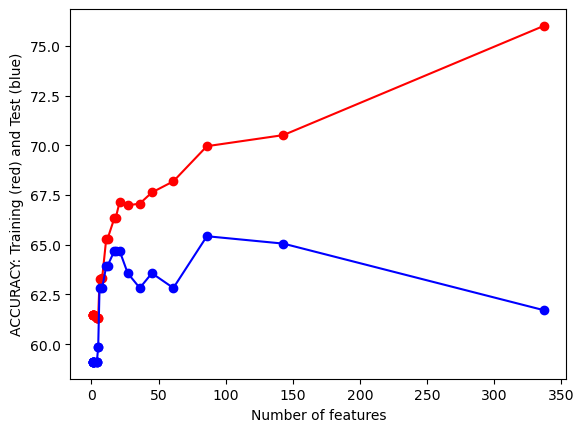

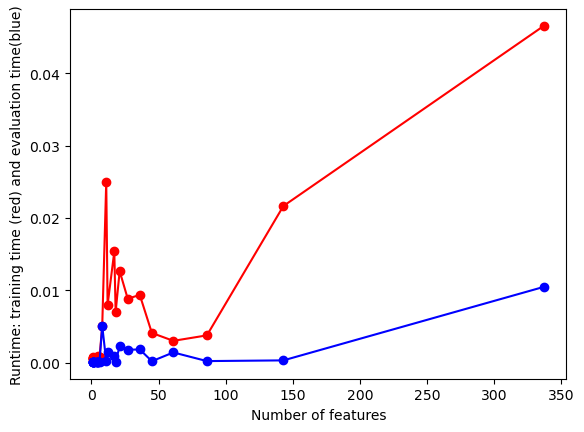

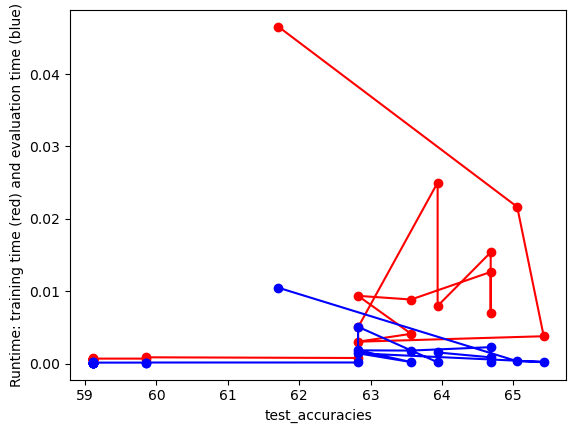

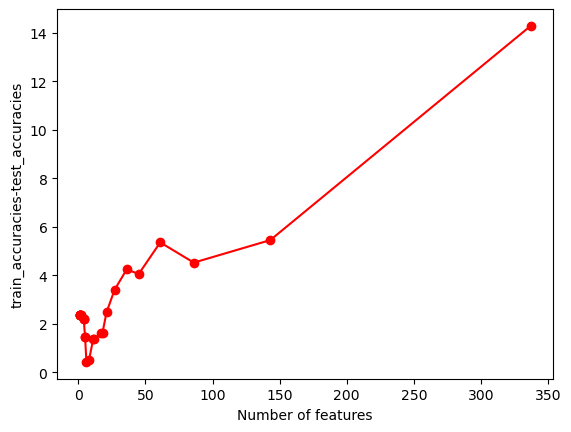

In [20]:
plot_results('results')

# Final results for Naïve Bayes (NB) with Labeled Record Data

**Report and comment on the findings. It is required that you create code, appropriate visualizations, result summaries, confusion matrices, etc**
* The accuracy we get from the model is not greater than 90%, however, the balanced precision and recall shows that the model is still doing a good job

**Describe how the trained model is tested on the testing dataset.**
* Utilizing the optimal feature set identified in the previous section, we trained our Naive Bayes model on the record data. The model was then tested using the held-out test dataset to evaluate its predictive performance.

**Discuss the evaluation metrics used to assess the performance of the Naive Bayes classifier (e.g., accuracy, precision, recall, F1-score).**
* For classification problems, several metrics are commonly employed to evaluate the performance:
Accuracy: This is the most straightforward metric. It is the ratio of the number of correct predictions to the total predictions.
Precision: Measures the number of correct positive predictions divided by the number of positive predictions made.

**Discuss the concepts of overfitting and under-fitting and whether your model is doing it.**
* Overfitting occurs when a model learns the training data too well, capturing noise and outliers, thus performing poorly on new, unseen data.
* Under-fitting happens when the model fails to capture the underlying trend of the data, leading to poor performance on both the training and test datasets.
* The accuracy of training and testing does not have a significant difference. However, the accuracy of both training and test seems have a poor performance which could suggest a under-fitting.

**Discuss the model’s performance in terms of accuracy and other relevant metrics.**
* The Naive Bayes classifier achieved an accuracy of 88% which could be count as good performance

**Describe how the project findings will be documented and reported, including the format of reports or presentations.**
* The findings of this project will be documented in a detailed report that includes:
* Descriptive statistics of the dataset.
* Visualizations that show the distribution of the data, feature importance, and the performance of our model.
* A confusion matrix to provide insights into the types of errors our model is making.

**e.g. what is the output that you generate. What does the output mean? What does it tell you about your data? Does your model do a good job of predicting your test data? Include and discuss relevant visualizations, results, the confusion matrices, etc。**
* For the 88% of accuracy of the model, I can predict that when a comment is been identified as a status of level, there is a strong likelihood that prediction is accurate.

**Write a conclusion paragraph interpreting the results. Note, this is not the same as a write-up of technical methodological details.**
* It's evident that our model demonstrates a commendable ability to discern between the positive and negative classes in the provided dataset. While the overall accuracy is robust, signaling a general correctness in predictions. This high precision suggests that when our model identifies an instance as positive, there's a strong likelihood of that prediction being accurate, minimizing the risk of false alarms. 
